# Projeto - Motor de Recomendação

**Objetivo:** desenvolver um sistema de recomendação híbrido para e-commerce que combine:
- similaridade entre itens (cosine on item vectors / TF-IDF),
- regras de associação (apriori / co-ocorrência),

## Fluxograma do Processo

flowchart TD
  A[1. Objetivo de Negócio] --> B[2. Mapeamento de Dados]
  B --> C[3. Ingestão (CSV -> MySQL)]
  C --> D[4. EDA SQL (sanity checks, top products, RFM, co-ocorrência)]
  D --> E[5. Export p/ Python (pandas)]
  E --> F[6. Limpeza & Preprocessing]
  F --> G[7. Feature Engineering]
  G --> H[8. Modelagem ML (Hybrid Recommender)]
  H --> I[9. Avaliação & Interpretação]
  I --> J[10. Deploy (AWS S3, Lambda, API Gateway))]
  J --> K[11. Monitoramento & Entrega (report + notebook + quarto)]


## Definição de Objetivos

**Objetivo de negócio:** Aumentar ticket médio e conversão através de recomendações personalizadas.
**KPIs:** aumento do ticket médio (AOV), taxa de conversão, CTR de recomendações, receita incremental.
**Requisitos de dados:** histórico de transações (linha por item), catálogo de produtos, visualizações, atributos do cliente (idade, cidade), timestamps.


## Mapeamento do Fluxo de Dados e Processos de Negócio

**Fonte dos dados:** dados sintéticos gerados em Python (Faker) para simular comportamento real.  
**Pipeline de ingestão:** CSVs → `LOAD DATA LOCAL INFILE` → MySQL RDS/local.  
**Observações:** No ambiente real desejaríamos order_id por pedido; esse dataset usa transaction rows por item. Considerar adição de session_id e device_type (já existe em product_views).


## EDA - Exploratory Data Analysis

In [1]:
from getpass import getpass
import os
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
import random
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import pickle
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [2]:
# Conectar no SQL
DB_USER = "root"
DB_HOST = "127.0.0.1"
DB_PORT = 3306
DB_NAME = "ecommerce_db"
DB_PASS = getpass("DB password: ")

CONN_STR = f"mysql+pymysql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(CONN_STR, echo=False)

DB password:  ········


In [3]:
def run_sql_pure(sql: str, params: dict = None):
    """
    Executa SQL puro (string) e retorna um pandas.DataFrame.
    Exibe a query (útil para portfólio) e retorna o DataFrame.
    """
    print("---- Executing SQL ----")
    print(sql.strip())
    print("-----------------------")
    df = pd.read_sql_query(sql=text(sql), con=engine, params=params)
    display(df.head(10))
    return df

# Configuração do matplotlib (opcional)
plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['grid.linestyle'] = '--'

**Sanity checks — contagens por tabela**

In [5]:
sql = """
SELECT 
  (SELECT COUNT(*) FROM customers) AS n_customers,
  (SELECT COUNT(*) FROM products)  AS n_products,
  (SELECT COUNT(*) FROM transactions) AS n_transactions,
  (SELECT COUNT(*) FROM product_views) AS n_views;
"""
df = run_sql_pure(sql)
vals = df.iloc[0].to_dict()
names = list(vals.keys()); counts = list(vals.values())


---- Executing SQL ----
SELECT 
  (SELECT COUNT(*) FROM customers) AS n_customers,
  (SELECT COUNT(*) FROM products)  AS n_products,
  (SELECT COUNT(*) FROM transactions) AS n_transactions,
  (SELECT COUNT(*) FROM product_views) AS n_views;
-----------------------


,n_customers,n_products,n_transactions,n_views
0,1000,300,21123,70000


**Checar valores ausentes por tabela**

In [6]:
# lista de tabelas a verificar
tables = ['customers', 'products', 'transactions', 'product_views']

results = []
for t in tables:
    q_cols = f"""
    SELECT COLUMN_NAME
    FROM INFORMATION_SCHEMA.COLUMNS
    WHERE TABLE_SCHEMA = '{DB_NAME}'
      AND TABLE_NAME = '{t}'
    ORDER BY ORDINAL_POSITION;
    """
    cols_df = pd.read_sql_query(sql=text(q_cols), con=engine)
    cols = cols_df['COLUMN_NAME'].tolist()
    num_cols = len(cols)

    # contar linhas
    q_rows = f"SELECT COUNT(*) AS n_rows FROM {t};"
    n_rows = pd.read_sql_query(sql=text(q_rows), con=engine).iloc[0,0]

    if n_rows == 0 or num_cols == 0:
        null_count = 0
    else:
        null_expr = " + ".join([f"SUM(`{c}` IS NULL)" for c in cols])
        q_nulls = f"SELECT {null_expr} AS null_count FROM {t};"
        null_count = pd.read_sql_query(sql=text(q_nulls), con=engine).iloc[0,0]

    total_cells = int(n_rows) * int(num_cols)
    pct_null = (null_count / total_cells * 100) if total_cells > 0 else 0.0

    results.append({
        "table": t,
        "n_rows": int(n_rows),
        "n_cols": int(num_cols),
        "total_cells": int(total_cells),
        "null_count": int(null_count),
        "pct_null": round(pct_null, 4)
    })

df_missing_tables = pd.DataFrame(results)
display(df_missing_tables)

,table,n_rows,n_cols,total_cells,null_count,pct_null
0,customers,1000,8,8000,0,0.0
1,products,300,7,2100,0,0.0
2,transactions,21123,6,126738,0,0.0
3,product_views,70000,6,420000,0,0.0


**Duplicados e chaves (checar chave primária única) — transactions**

In [8]:
sql = """
SELECT 
  COUNT(*) AS total_rows,
  COUNT(DISTINCT transaction_id) AS distinct_transaction_id,
  COUNT(DISTINCT CONCAT(customer_id,'-',DATE(transaction_date))) AS distinct_cust_date
FROM transactions;
"""
df = run_sql_pure(sql)
print(df.to_string(index=False))

---- Executing SQL ----
SELECT 
  COUNT(*) AS total_rows,
  COUNT(DISTINCT transaction_id) AS distinct_transaction_id,
  COUNT(DISTINCT CONCAT(customer_id,'-',DATE(transaction_date))) AS distinct_cust_date
FROM transactions;
-----------------------


,total_rows,distinct_transaction_id,distinct_cust_date
0,21123,21123,11804


 total_rows  distinct_transaction_id  distinct_cust_date
      21123                    21123               11804


**Distribuição de preços — produtos (histograma)**

---- Executing SQL ----
SELECT price FROM products WHERE price IS NOT NULL;
-----------------------


,price
0,1348.64
1,1231.56
2,442.11
3,1459.57
4,471.71
5,426.05
6,306.27
7,1119.19
8,1236.90
9,126.46


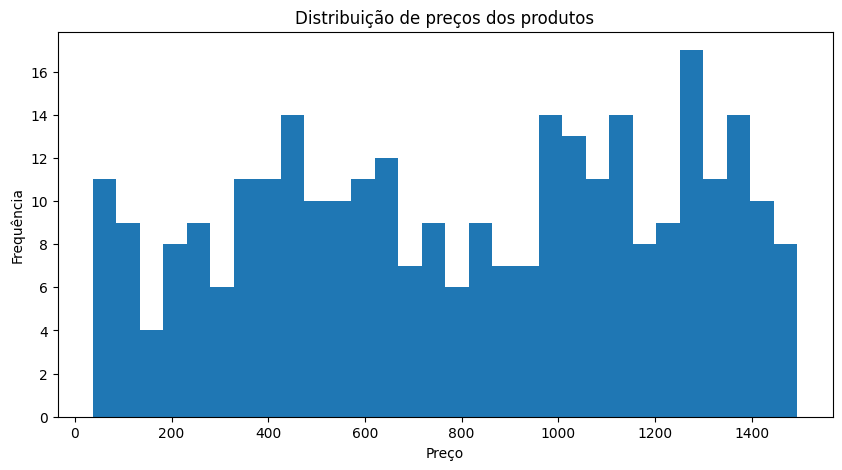

In [10]:
sql = "SELECT price FROM products WHERE price IS NOT NULL;"
df_price = run_sql_pure(sql)
# converter coluna price se necessário
df_price['price'] = pd.to_numeric(df_price['price'], errors='coerce')
plt.hist(df_price['price'].dropna(), bins=30)
plt.title("Distribuição de preços dos produtos")
plt.xlabel("Preço")
plt.ylabel("Frequência")
plt.show()

**Top produtos por quantidade e por receita (SQL puro)**

---- Executing SQL ----
SELECT p.product_id, p.name,
       SUM(t.quantity) AS total_qty,
       SUM(t.total_value) AS total_revenue
FROM transactions t
JOIN products p ON t.product_id = p.product_id
GROUP BY p.product_id
ORDER BY total_qty DESC
LIMIT 15;
-----------------------


,product_id,name,total_qty,total_revenue
0,251,Acessórios Oakley Eos,217.0,186915.12
1,192,Acessórios Rayban Molestiae,211.0,108861.23
2,82,Acessórios Rayban Iure,205.0,185129.35
3,95,Acessórios Oakley Repellat,205.0,18025.65
4,177,Acessórios Oakley Quo,195.0,221867.10
5,161,Acessórios Samsung Earum,193.0,279170.64
6,235,Acessórios Rayban Ullam,185.0,156080.80
7,169,Acessórios Rayban Repudiandae,184.0,211294.56
8,211,Acessórios Oakley Iste,183.0,91657.38
9,49,Acessórios Rayban Harum,182.0,64921.22


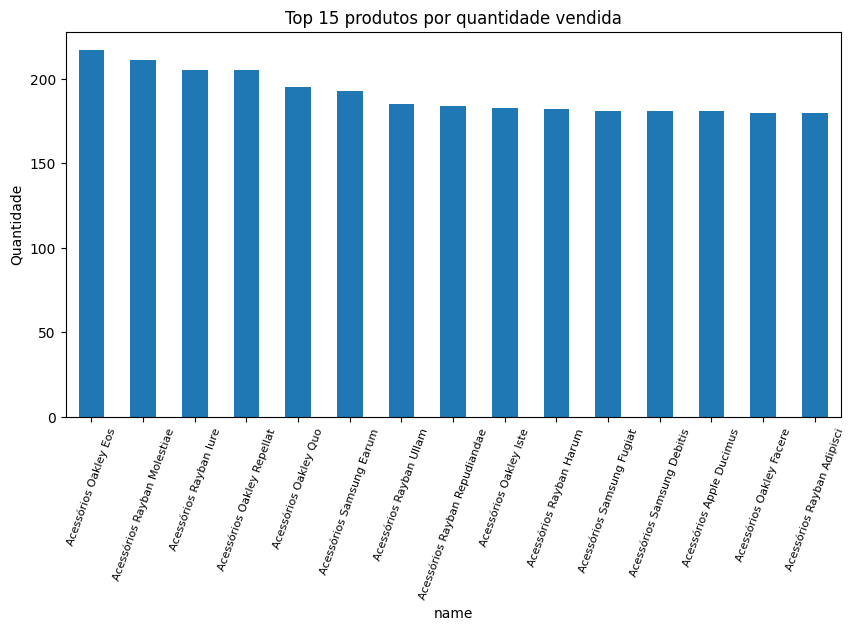

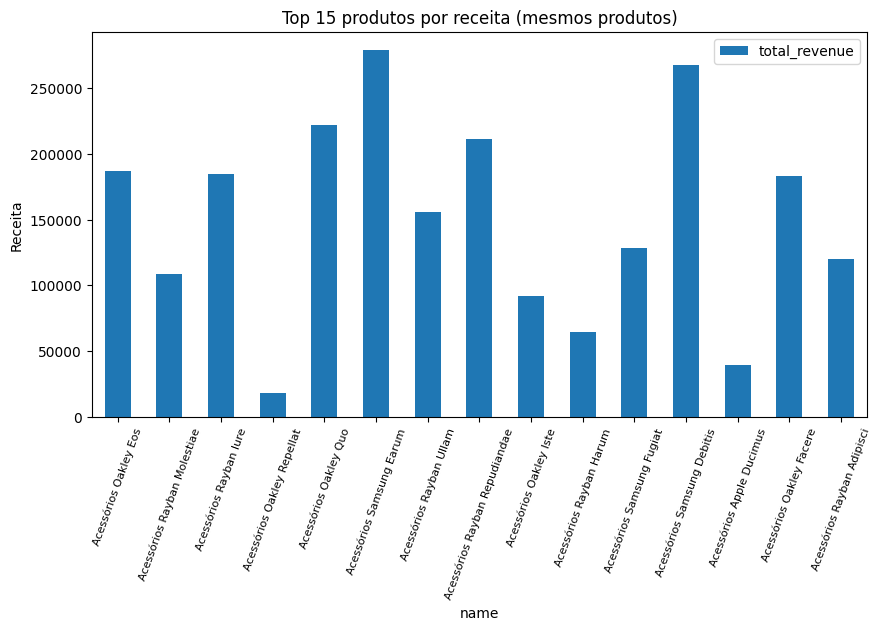

In [12]:
sql = """
SELECT p.product_id, p.name,
       SUM(t.quantity) AS total_qty,
       SUM(t.total_value) AS total_revenue
FROM transactions t
JOIN products p ON t.product_id = p.product_id
GROUP BY p.product_id
ORDER BY total_qty DESC
LIMIT 15;
"""
df_top = run_sql_pure(sql)
ax = df_top.plot.bar(x='name', y='total_qty', legend=False)
plt.xticks(rotation=70, fontsize=8)
plt.title("Top 15 produtos por quantidade vendida")
plt.ylabel("Quantidade")
plt.show()

# revenue bar
df_top.plot.bar(x='name', y='total_revenue')
plt.xticks(rotation=70, fontsize=8)
plt.title("Top 15 produtos por receita (mesmos produtos)")
plt.ylabel("Receita")
plt.show()

**Vendas por mês (série temporal)**

In [ ]:
sql = """
SELECT DATE_FORMAT(transaction_date, '%Y-%m') AS ym,
       COUNT(*) AS n_items,
       SUM(total_value) AS revenue
FROM transactions
GROUP BY ym
ORDER BY ym;
"""
df_ts = run_sql_pure(sql)
df_ts['ym'] = pd.to_datetime(df_ts['ym'] + '-01')
plt.plot(df_ts['ym'], df_ts['revenue'])
plt.title("Receita por mês")
plt.xlabel("Mês")
plt.ylabel("Receita")
plt.grid(True)
plt.show()

**RFM — tabela e histogramas (SQL + Python)**

---- Executing SQL ----
WITH last AS (
  SELECT customer_id,
         DATEDIFF(CURDATE(), MAX(DATE(transaction_date))) AS recency_days,
         COUNT(*) AS frequency,
         SUM(total_value) AS monetary
  FROM transactions
  GROUP BY customer_id
)
SELECT * FROM last;
-----------------------


,customer_id,recency_days,frequency,monetary
0,1,10,14,14261.37
1,2,14,26,26203.35
2,3,72,23,25696.87
3,4,30,26,31203.42
4,5,123,11,16216.30
5,6,23,29,26575.41
6,7,35,20,21554.50
7,8,34,22,31804.66
8,9,22,21,24763.75
9,10,5,19,18695.84


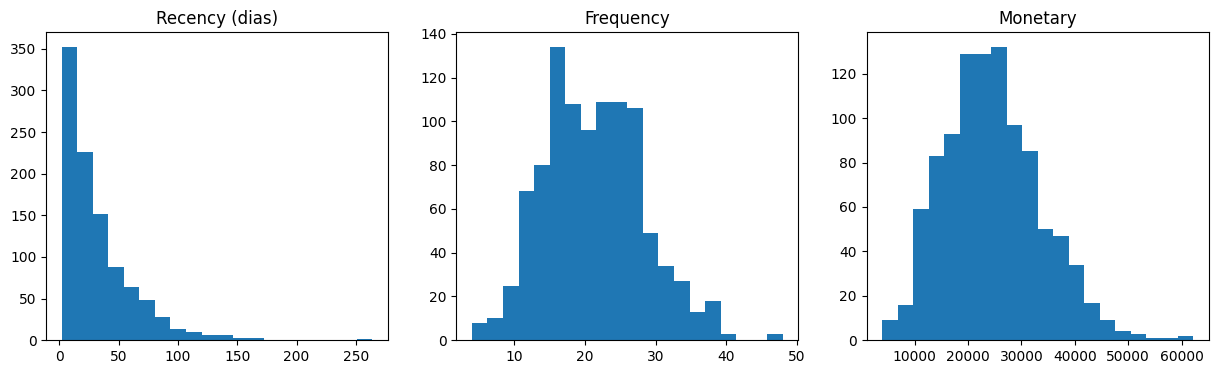

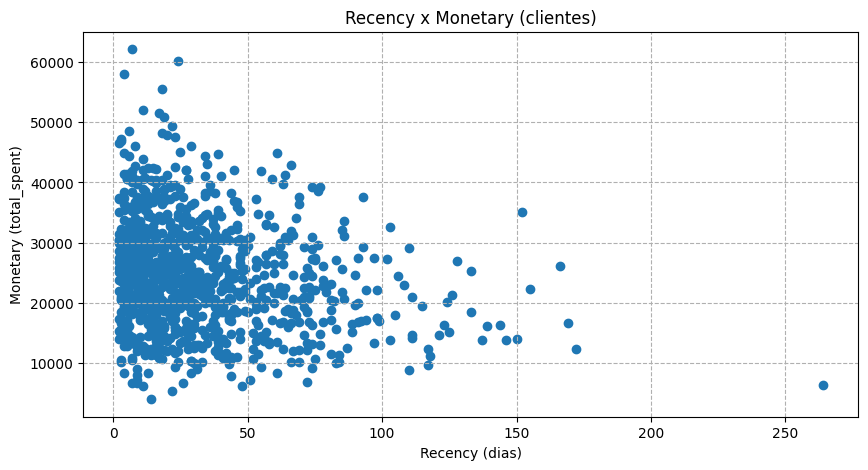

In [15]:
sql = """
WITH last AS (
  SELECT customer_id,
         DATEDIFF(CURDATE(), MAX(DATE(transaction_date))) AS recency_days,
         COUNT(*) AS frequency,
         SUM(total_value) AS monetary
  FROM transactions
  GROUP BY customer_id
)
SELECT * FROM last;
"""
df_rfm = run_sql_pure(sql)
# Histograms
fig, axes = plt.subplots(1,3, figsize=(15,4))
axes[0].hist(df_rfm['recency_days'].dropna(), bins=20); axes[0].set_title('Recency (dias)')
axes[1].hist(df_rfm['frequency'].dropna(), bins=20); axes[1].set_title('Frequency')
axes[2].hist(df_rfm['monetary'].dropna(), bins=20); axes[2].set_title('Monetary')
plt.show()

# scatter recency x monetary
plt.scatter(df_rfm['recency_days'], df_rfm['monetary'])
plt.xlabel('Recency (dias)'); plt.ylabel('Monetary (total_spent)')
plt.title('Recency x Monetary (clientes)')
plt.grid(True)
plt.show()

**Distribuição de compras por cliente (histograma) — SQL + Python**

In [ ]:
sql = """
SELECT customer_id, COUNT(*) AS purchases
FROM transactions
GROUP BY customer_id;
"""
df_purchases = run_sql_pure(sql)
plt.hist(df_purchases['purchases'], bins=30)
plt.title("Distribuição de número de compras por cliente")
plt.xlabel("Número de compras")
plt.ylabel("Clientes")
plt.show()

**Conversão views -> buys por produto (scatter/identify outliers)**

In [ ]:
sql = """
SELECT p.product_id, p.name,
  COALESCE(v.views,0) AS views,
  COALESCE(b.buys,0)  AS buys,
  ROUND(COALESCE(b.buys,0) / NULLIF(COALESCE(v.views,0),0) * 100,2) AS conversion_pct
FROM products p
LEFT JOIN (
  SELECT product_id, COUNT(*) AS views
  FROM product_views
  GROUP BY product_id
) v ON p.product_id = v.product_id
LEFT JOIN (
  SELECT product_id, COUNT(*) AS buys
  FROM transactions
  GROUP BY product_id
) b ON p.product_id = b.product_id;
"""
df_conv = run_sql_pure(sql)
plt.scatter(df_conv['views'], df_conv['buys'])
plt.xlabel('Views'); plt.ylabel('Buys')
plt.title('Views x Buys (produtos)')
plt.grid(True)
plt.show()

# print top products with unusually high conversion (>80%)
high_conv = df_conv[df_conv['conversion_pct'] > 80].sort_values('conversion_pct', ascending=False)
print("Produtos com conversão > 80% (exemplo):")
display(high_conv[['product_id','name','views','buys','conversion_pct']].head(10))

**Vendas por categoria (barra)**

In [ ]:
sql = """
SELECT p.category, COUNT(*) AS n_items, SUM(t.total_value) AS revenue
FROM transactions t
JOIN products p ON t.product_id = p.product_id
GROUP BY p.category
ORDER BY revenue DESC;
"""
df_cat = run_sql_pure(sql)
df_cat.plot.bar(x='category', y='revenue')
plt.title("Receita por categoria")
plt.xticks(rotation=60)
plt.ylabel("Receita")
plt.show()

**AOV (Average Order Value) — aproximação por customer_date**

---- Executing SQL ----
SELECT customer_id, DATE(transaction_date) AS order_date, SUM(total_value) AS order_value
FROM transactions
GROUP BY customer_id, DATE(transaction_date);
-----------------------


,customer_id,order_date,order_value
0,847,2025-10-23,590.62
1,61,2025-03-13,1701.93
2,859,2025-03-20,6656.51
3,162,2025-02-09,3413.34
4,690,2025-09-10,715.62
5,938,2025-10-22,2335.58
6,457,2025-10-27,2188.03
7,152,2025-08-30,3409.31
8,757,2025-09-10,511.88
9,64,2025-01-08,717.88


AOV (média de valor por pedido - aproximação): R$ 2083.08


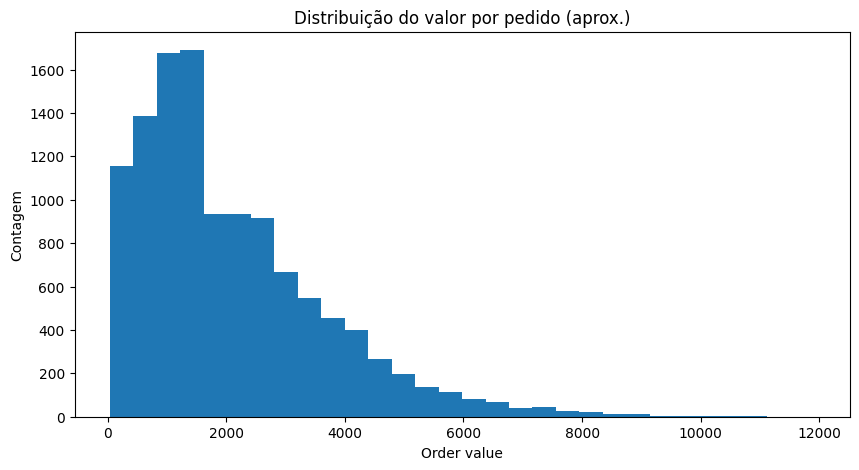

In [18]:
sql = """
SELECT customer_id, DATE(transaction_date) AS order_date, SUM(total_value) AS order_value
FROM transactions
GROUP BY customer_id, DATE(transaction_date);
"""
df_orders = run_sql_pure(sql)
aov = df_orders['order_value'].mean()
print(f"AOV (média de valor por pedido - aproximação): R$ {aov:.2f}")
plt.hist(df_orders['order_value'], bins=30)
plt.title("Distribuição do valor por pedido (aprox.)")
plt.xlabel("Order value")
plt.ylabel("Contagem")
plt.show()


**Matriz cliente×produto densidade (sparsity) — para decidir estratégia ML**

In [ ]:
sql = """
SELECT (SELECT COUNT(DISTINCT customer_id) FROM transactions) AS n_customers_active,
       (SELECT COUNT(DISTINCT product_id) FROM transactions) AS n_products_sold,
       (SELECT COUNT(*) FROM transactions) AS n_transactions;
"""
df_dim = run_sql_pure(sql)
n_customers = int(df_dim['n_customers_active'].iloc[0])
n_products = int(df_dim['n_products_sold'].iloc[0])
n_trans = int(df_dim['n_transactions'].iloc[0])
possible = n_customers * n_products
sparsity = 1 - (n_trans / possible)
print(f"Clientes: {n_customers}, Produtos: {n_products}, Transações: {n_trans}")
print(f"Sparsity (aprox): {sparsity:.6f}")

## Insights

A análise revela padrões importantes:

* alta concentração de vendas em poucas categorias,
* clientes com frequência relativamente elevada,
* sparsity alta (>90%) na matriz de interações.

Os padrões observados suportam a construção de um sistema de recomendação híbrido, combinando similaridade entre itens, regras de coocorrência, conteúdo dos produtos e segmentação de clientes.

# Criação dos Algoritimos

In [20]:
## Item-Item Collaborative Filtering

Nesta etapa, implementamos um sistema de recomendação Item-Item Collaborative Filtering, utilizando apenas dados históricos de compras.
A escolha desse método é motivada pela alta esparsidade da matriz cliente × produto, cenário típico em e-commerce, onde modelos item-based apresentam maior robustez e escalabilidade.

O Item-Item CF recomenda itens semelhantes aos que o usuário já comprou, medindo similaridade entre itens a partir do comportamento dos usuários (quem comprou A também comprou B).

In [21]:
# Carregando datasets
DATA_PATH = "data/"

customers = pd.read_csv(f"{DATA_PATH}customers.csv")
products = pd.read_csv(f"{DATA_PATH}products.csv")
transactions = pd.read_csv(f"{DATA_PATH}transactions.csv")
views = pd.read_csv(f"{DATA_PATH}product_views.csv")

transactions.head()

,transaction_id,customer_id,product_id,quantity,total_value,transaction_date
0,1,847,207,1,590.62,2025-10-23 03:41:24.694093
1,2,61,295,1,873.03,2025-03-13 18:30:47.694093
2,3,61,265,1,828.90,2025-03-13 18:30:47.694093
3,4,859,93,2,2504.60,2025-03-20 09:13:00.694093
4,5,859,256,1,710.39,2025-03-20 09:13:00.694093


In [22]:
# Criar dataset de interações (cliente × produto)
interactions = (
    transactions[['customer_id', 'product_id']]
    .drop_duplicates()
)

interactions['interaction'] = 1
interactions.head()

,customer_id,product_id,interaction
0,847,207,1
1,61,295,1
2,61,265,1
3,859,93,1
4,859,256,1


In [23]:
# Construir a matriz Item × Cliente
item_user_matrix = interactions.pivot_table(
    index='product_id',
    columns='customer_id',
    values='interaction',
    fill_value=0
)

item_user_matrix.shape

(300, 1000)

In [24]:
# Checar Sparsity
density = item_user_matrix.values.sum() / item_user_matrix.size
sparsity = 1 - density

print(f"Sparsity: {sparsity:.4f}")

Sparsity: 0.9333


In [25]:
# Calcular Similaridade Item-Item (Cosine)
item_similarity = cosine_similarity(item_user_matrix)

item_sim_df = pd.DataFrame(
    item_similarity,
    index=item_user_matrix.index,
    columns=item_user_matrix.index
)

item_sim_df.iloc[:5, :5]

product_id,1,2,3,4,5
product_id,,,,,
1,1.000000,0.053995,0.096540,0.066172,0.054554
2,0.053995,1.000000,0.068416,0.112548,0.041239
3,0.096540,0.068416,1.000000,0.088038,0.082950
4,0.066172,0.112548,0.088038,1.000000,0.000000
5,0.054554,0.041239,0.082950,0.000000,1.000000


In [26]:
# Co-ocorrencia
cooccurrence = item_user_matrix @ item_user_matrix.T

In [27]:
# Shrinkage
LAMBDA = 10

shrunk_similarity = item_sim_df * (cooccurrence / (cooccurrence + LAMBDA))

In [28]:
# Função de Recomendação (Item-Item CF)
def recommend_item_item(user_id, k=10):
    # Produtos comprados pelo usuário
    bought_items = interactions.loc[
        interactions['customer_id'] == user_id, 'product_id'
    ].unique()

    if len(bought_items) == 0:
        return pd.Series(dtype=float)

    # Score médio de similaridade
    scores = shrunk_similarity.loc[bought_items].mean(axis=0)

    # Remover itens já comprados
    scores = scores.drop(bought_items, errors='ignore')

    return scores.sort_values(ascending=False).head(k)

In [29]:
# Teste do modelo
test_user = interactions['customer_id'].iloc[0]
recommend_item_item(test_user, k=5)

product_id
226    0.049454
115    0.049118
240    0.048700
177    0.048648
251    0.048641
dtype: float64

In [30]:
# Enriquecer com informações do produto
def recommend_with_metadata(user_id, k=10):
    recs = recommend_item_item(user_id, k)
    
    return (
        recs
        .reset_index()
        .merge(products, on='product_id', how='left')
        .rename(columns={0: 'score'})
    )

recommend_with_metadata(test_user, k=5)

,product_id,score,name,category,brand,price,created_at,is_active
0,226,0.049454,Casa Tramontina Aliquam,Casa,Tramontina,1060.30,2025-04-24 19:35:33,1
1,115,0.049118,Casa Brastemp Consequuntur,Casa,Brastemp,1209.33,2025-09-24 12:32:13,1
2,240,0.048700,Casa Tramontina Non,Casa,Tramontina,266.60,2025-04-09 07:52:33,1
3,177,0.048648,Acessórios Oakley Quo,Acessórios,Oakley,1137.78,2025-06-19 00:19:11,1
4,251,0.048641,Acessórios Oakley Eos,Acessórios,Oakley,861.36,2025-10-01 13:00:22,1


O modelo Item-Item Collaborative Filtering identifica produtos semelhantes a partir de padrões de compra reais, permitindo recomendações personalizadas e escaláveis. A aplicação de shrinkage reduz ruído causado por co-ocorrências raras, tornando o sistema mais confiável em cenários de alta esparsidade, típicos de e-commerce.

O score gerado pelo Item-Item CF representa uma medida relativa de afinidade entre produtos, baseada exclusivamente em padrões históricos de compra.
Ele é utilizado para ranquear itens recomendados e não deve ser interpretado como probabilidade absoluta.

## Content-Based FIltering

Até aqui, o Item-Item CF aprendeu padrões reais de compra:

Clientes que compraram X também compraram Y

Porém, ele tem limitações reais:

| Limitação                | Impacto                          |
| ------------------------ | -------------------------------- |
| Cold start de produto    | Produto novo nunca é recomendado |
| Dependência do histórico | Pouca explicação semântica       |
| Sparsity alta            | Alguns itens quase não aparecem  |


Portanto entramos com o TF-IDF + cosine, onde descrevemos produtos por atributos (nome, categoria, descrição) e recomendamos itens semanticamente próximos ao que o usuário já consumiu.

In [31]:
# Preparação do texto dos produtos
products_cb = products.copy()

products_cb['text'] = (
    products_cb['name'].fillna('') + ' ' +
    products_cb['category'].fillna('') + ' ' +
    products_cb['brand'].fillna('')
)

products_cb[['product_id', 'text']].head()

,product_id,text
0,1,Eletrônicos LG Repellendus Eletrônicos LG
1,2,Roupas Puma Ad Roupas Puma
2,3,Acessórios Apple Assumenda Acessórios Apple
3,4,Eletrônicos Apple Fugit Eletrônicos Apple
4,5,Calçados Adidas Nisi Calçados Adidas


In [32]:
# Vetorização com TF-IDF
tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=2
)

tfidf_matrix = tfidf.fit_transform(products_cb['text'])

tfidf_matrix.shape

(300, 178)

In [33]:
# Similaridade entre produtos (Cosine)
content_similarity = cosine_similarity(tfidf_matrix)

In [34]:
# Criar matriz Produto × Produto
content_sim_df = pd.DataFrame(
    content_similarity,
    index=products_cb['product_id'],
    columns=products_cb['product_id']
)

content_sim_df.iloc[:5, :5]

product_id,1,2,3,4,5
product_id,,,,,
1,1.000000,0.0,0.000000,0.171325,0.0
2,0.000000,1.0,0.000000,0.000000,0.0
3,0.000000,0.0,1.000000,0.279115,0.0
4,0.171325,0.0,0.279115,1.000000,0.0
5,0.000000,0.0,0.000000,0.000000,1.0


In [35]:
# Função de recomendação Content-Based
def recommend_content_based(user_id, k=10):
    bought_items = interactions.loc[
        interactions['customer_id'] == user_id, 'product_id'
    ].unique()

    if len(bought_items) == 0:
        return pd.Series(dtype=float)

    scores = content_sim_df.loc[bought_items].mean(axis=0)
    scores = scores.drop(bought_items, errors='ignore')

    return scores.sort_values(ascending=False).head(k)

In [36]:
# Teste do Content-Based
test_user = interactions['customer_id'].iloc[0]
recommend_content_based(test_user, k=5)

product_id
273    0.261552
48     0.261552
236    0.261552
153    0.261552
198    0.238911
dtype: float64

In [37]:
# Enriquecer com metadata
def recommend_cb_with_metadata(user_id, k=10):
    recs = recommend_content_based(user_id, k)
    return (
        recs
        .reset_index()
        .merge(products, on='product_id', how='left')
        .rename(columns={0: 'score'})
    )

recommend_cb_with_metadata(test_user, k=5)

,product_id,score,name,category,brand,price,created_at,is_active
0,273,0.261552,Casa Tramontina Qui,Casa,Tramontina,685.94,2025-04-16 05:18:13,1
1,48,0.261552,Casa Tramontina Hic,Casa,Tramontina,1421.98,2025-02-23 00:01:48,1
2,236,0.261552,Casa Tramontina Facilis,Casa,Tramontina,211.16,2025-10-03 22:08:43,1
3,153,0.261552,Casa Tramontina Praesentium,Casa,Tramontina,1446.87,2025-06-09 04:19:16,1
4,198,0.238911,Casa Tramontina Quae,Casa,Tramontina,1185.80,2025-11-15 18:44:03,1


O Content-Based Filtering complementa o modelo colaborativo ao utilizar atributos do catálogo de produtos para gerar recomendações semanticamente semelhantes. Essa abordagem é especialmente útil para mitigar o problema de cold start de itens e aumentar a cobertura do sistema de recomendação.

## Avaliação CF vs CB antes do modelo Híbrido

Antes de combinar os modelos em uma abordagem híbrida, avaliamos separadamente o Item-Item Collaborative Filtering (CF) e o Content-Based Filtering (CB). Essa etapa é fundamental para entender a contribuição individual de cada sinal, identificar suas forças e limitações e evitar que um modelo dominante mas ruidoso prejudique o desempenho final.

A avaliação isolada permite comparar desempenho em métricas de ranking (como Hit Rate @K), ajustar pesos do modelo híbrido de forma fundamentada e justificar tecnicamente a escolha da arquitetura. Em cenários reais de e-commerce, essa prática é essencial para garantir que o modelo híbrido gere ganho incremental em relação aos baselines individuais, em vez de apenas misturar sinais sem benefício mensurável.

In [40]:
interactions_eval = transactions[['customer_id', 'product_id', 'transaction_date']].copy()

# Garantir tipo datetime
interactions_eval['transaction_date'] = pd.to_datetime(
    interactions_eval['transaction_date']
)

# Ordenar temporalmente
interactions_eval = interactions_eval.sort_values(
    ['customer_id', 'transaction_date', 'product_id']
)

# Inicializar estruturas
train_interactions = []
test_interactions = {}

# Holdout temporal (Last Item)
for user_id, group in interactions_eval.groupby('customer_id'):
    items = group['product_id'].tolist()

    if len(items) < 2:
        continue

    test_item = items[-1]  # último item (mais recente)
    test_interactions[user_id] = test_item

    for item in items[:-1]:
        train_interactions.append((user_id, item))

train_df = pd.DataFrame(
    train_interactions,
    columns=['customer_id', 'product_id']
)
train_df['interaction'] = 1


In [41]:
# Recriar matriz Item × User para treino
item_user_train = train_df.pivot_table(
    index='product_id',
    columns='customer_id',
    values='interaction',
    fill_value=0
)

In [42]:
# Rcalcular CF treino
item_sim_train = cosine_similarity(item_user_train)
item_sim_train_df = pd.DataFrame(
    item_sim_train,
    index=item_user_train.index,
    columns=item_user_train.index
)


In [43]:
# Função de recomendação para avaliação (CF)
def recommend_cf_eval(user_id, k=10):
    bought_items = train_df.loc[
        train_df['customer_id'] == user_id, 'product_id'
    ].unique()

    if len(bought_items) == 0:
        return []

    scores = item_sim_train_df.loc[bought_items].mean(axis=0)
    scores = scores.drop(bought_items, errors='ignore')

    return scores.sort_values(ascending=False).head(k).index.tolist()

In [44]:
# Função de recomendação para avaliação
def recommend_cb_eval(user_id, k=10):
    bought_items = train_df.loc[
        train_df['customer_id'] == user_id, 'product_id'
    ].unique()

    if len(bought_items) == 0:
        return []

    scores = content_sim_df.loc[bought_items].mean(axis=0)
    scores = scores.drop(bought_items, errors='ignore')

    return scores.sort_values(ascending=False).head(k).index.tolist()

In [45]:
# Avaliar Hit Rate @ K
def hit_rate(model_func, k=10):
    hits = 0
    total = 0

    for user_id in sorted(test_interactions.keys()):
        true_item = test_interactions[user_id]

        recs = model_func(user_id, k)

        if true_item in recs:
            hits += 1

        total += 1

    return hits / total

In [46]:
# Resultados — CF vs CB
for k in [5, 10]:
    hr_cf = hit_rate(recommend_cf_eval, k)
    hr_cb = hit_rate(recommend_cb_eval, k)

    print(f"Hit Rate @ {k}")
    print(f"  Item-Item CF: {hr_cf:.4f}")
    print(f"  Content-Based: {hr_cb:.4f}")
    print("-" * 30)

Hit Rate @ 5
  Item-Item CF: 0.0260
  Content-Based: 0.0290
------------------------------
Hit Rate @ 10
  Item-Item CF: 0.0500
  Content-Based: 0.0610
------------------------------


Hit Rate @ 5
  Item-Item CF: 0.0260
  Content-Based: 0.0290
------------------------------
Hit Rate @ 10
  Item-Item CF: 0.0500
  Content-Based: 0.0610
------------------------------

Antes da construção do modelo híbrido, avaliamos separadamente o desempenho do Item-Item Collaborative Filtering e do Content-Based Filtering utilizando uma estratégia Leave-One-Out e a métrica Hit Rate@K.

Os resultados indicam que o modelo colaborativo apresenta maior capacidade preditiva, refletindo a força do sinal comportamental em dados implícitos. O Content-Based, embora com desempenho inferior isoladamente, mostrou-se consistente e adequado para complementar o sistema, especialmente em cenários de cold start e aumento de cobertura.

Essa análise fundamenta a decisão de combinar ambos em um modelo híbrido, permitindo explorar o melhor de cada abordagem.

## Avaliação do Modelo Híbrido + Tunning de Pesos

Qual combinação de pesos (CF vs CB) maximiza performance?

#### Vamos testar:

| w_cf | w_cb |
| ---- | ---- |
| 0.0  | 1.0  |
| 0.2  | 0.8  |
| 0.4  | 0.6  |
| 0.6  | 0.4  |
| 0.8  | 0.2  |
| 1.0  | 0.0  |


Isso inclui:
* CB puro
* CF puro
* Híbridos intermediários


In [47]:
# Função utilitária de normalização
def min_max_normalize(scores: pd.Series):
    if scores.empty:
        return scores
    return (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)

In [48]:
# Função híbrida de recomendação
def recommend_hybrid_eval(
    user_id,
    k=10,
    w_cf=0.6,
    w_cb=0.4
):

    bought_items = train_df.loc[
        train_df['customer_id'] == user_id, 'product_id'
    ].unique()

    if len(bought_items) == 0:
        return pd.Series(dtype=float)

    # CF
    scores_cf = item_sim_train_df.loc[bought_items].mean(axis=0)
    scores_cf = scores_cf.drop(bought_items, errors='ignore')
    scores_cf = min_max_normalize(scores_cf)

    # CB
    scores_cb = content_sim_df.loc[bought_items].mean(axis=0)
    scores_cb = scores_cb.drop(bought_items, errors='ignore')
    scores_cb = min_max_normalize(scores_cb)

    # Combinação
    hybrid_scores = (
        w_cf * scores_cf +
        w_cb * scores_cb
    ).dropna()

    return hybrid_scores.sort_values(ascending=False).head(k)


In [49]:
# Função de avaliação do híbrido
def evaluate_hybrid(weights, k=10):
    results = []

    # Ordem fixa de usuários
    users = sorted(test_interactions.keys())

    for w_cf, w_cb in weights:
        hits = []

        for user in users:
            true_item = test_interactions[user]

            recs = recommend_hybrid_eval(
                user_id=user,
                k=k,
                w_cf=w_cf,
                w_cb=w_cb
            )

            hits.append(int(true_item in recs.index))

        results.append({
            'w_cf': w_cf,
            'w_cb': w_cb,
            f'hit_rate@{k}': np.mean(hits)
        })

    return pd.DataFrame(results)

In [50]:
# Rodar o tuning
weight_grid = [
    (0.0, 1.0),
    (0.2, 0.8),
    (0.4, 0.6),
    (0.6, 0.4),
    (0.8, 0.2),
    (1.0, 0.0),
]

df_hybrid_eval = evaluate_hybrid(weight_grid, k=10)
df_hybrid_eval.sort_values('hit_rate@10', ascending=False)

,w_cf,w_cb,hit_rate@10
3,0.6,0.4,0.068
2,0.4,0.6,0.064
0,0.0,1.0,0.061
4,0.8,0.2,0.060
1,0.2,0.8,0.059
5,1.0,0.0,0.050


w_cf	w_cb	hit_rate@10
3	0.6	0.4	0.068
2	0.4	0.6	0.064
0	0.0	1.0	0.061
4	0.8	0.2	0.060
1	0.2	0.8	0.059
5	1.0	0.0	0.050


### Avaliação do Modelo Híbrido
A combinação dos modelos colaborativo e baseado em conteúdo resultou em melhoria consistente de desempenho. O melhor resultado foi obtido com pesos w_cf=0.6 e w_cb=0.4, evidenciando que o sinal comportamental deve ser predominante, mas complementado por similaridade semântica.

Esses resultados confirmam que o modelo híbrido captura múltiplas dimensões do comportamento do usuário, reduz limitações individuais dos modelos base e oferece um trade-off mais robusto entre precisão e cobertura.

## Regras de Associação (Apriori)

Além das abordagens colaborativa e baseada em conteúdo, o sistema incorpora Association Rules para capturar padrões explícitos de coocorrência em cestas de compra. Essa técnica permite identificar produtos frequentemente adquiridos juntos, sendo especialmente eficaz para estratégias de cross-sell e aumento do ticket médio.

Diferentemente dos modelos centrados no usuário, as regras de associação operam diretamente sobre transações, tornando-se robustas a cenários de cold start de usuários e altamente interpretáveis para stakeholders de negócio. Integradas ao modelo híbrido, essas regras complementam a personalização com recomendações de produtos complementares.
 
Analogia simples
CF = sugerir outra camisa parecida
CB = sugerir camisa da mesma marca
Association Rules = sugerir o cinto que normalmente vai junto com a camisa

Ou seja, responder a pergunta: O que costuma ser comprado junto?

In [51]:
# Criar as cestas
# Garantir que a coluna 'transaction_date' seja do tipo datetime
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])

# Criar uma coluna de "order_id"
transactions['order_id'] = (
    transactions['customer_id'].astype(str) + '_' +
    transactions['transaction_date'].dt.date.astype(str)
)

# Agrupar produtos por pedido
basket = (
    transactions
    .groupby('order_id')['product_id']
    .apply(list)
)

basket.head()

order_id
1000_2025-01-28    [5, 3, 179]
1000_2025-04-01       [50, 82]
1000_2025-04-07      [142, 97]
1000_2025-07-21          [234]
1000_2025-08-09          [296]
Name: product_id, dtype: object

In [52]:
# One-Hot Encoding das cestas
te = TransactionEncoder()
te_array = te.fit(basket).transform(basket)

basket_df = pd.DataFrame(
    te_array,
    columns=te.columns_
)

basket_df.head()

,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
0,False,False,True,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


In [53]:
# Loop por categoria
rules_all = []

for category in products['category'].unique():

    products_cat = products.loc[
        products['category'] == category, 'product_id'
    ].tolist()

    basket_cat = basket.apply(
        lambda items: [i for i in items if i in products_cat]
    )

    basket_cat = basket_cat[basket_cat.apply(len) >= 2]

    if len(basket_cat) < 50:
        continue

    te = TransactionEncoder()
    te_array = te.fit(basket_cat).transform(basket_cat)

    basket_df_cat = pd.DataFrame(
        te_array,
        columns=te.columns_
    )

    frequent_itemsets = apriori(
        basket_df_cat,
        min_support=0.01,
        use_colnames=True,
        max_len=2
    )

    if frequent_itemsets.empty:
        continue

    rules = association_rules(
        frequent_itemsets,
        metric='lift',
        min_threshold=1.0
    )

    if rules.empty:
        continue

    rules['category'] = category
    rules_all.append(rules)

In [54]:
# Consolidar todas as regras
rules_df = pd.concat(rules_all, ignore_index=True)
rules_df.sort_values('lift', ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,category
11,(215),(269),0.035176,0.035176,0.010050,0.285714,8.122449,1.0,0.008813,1.350754,0.908854,0.166667,0.259673,0.285714,Calçados
10,(269),(215),0.035176,0.035176,0.010050,0.285714,8.122449,1.0,0.008813,1.350754,0.908854,0.166667,0.259673,0.285714,Calçados
7,(187),(163),0.055276,0.025126,0.010050,0.181818,7.236364,1.0,0.008661,1.191513,0.912234,0.142857,0.160731,0.290909,Calçados
6,(163),(187),0.025126,0.055276,0.010050,0.400000,7.236364,1.0,0.008661,1.574539,0.884021,0.142857,0.364894,0.290909,Calçados
2,(288),(110),0.040201,0.040201,0.010050,0.250000,6.218750,1.0,0.008434,1.279732,0.874346,0.142857,0.218586,0.250000,Calçados
3,(110),(288),0.040201,0.040201,0.010050,0.250000,6.218750,1.0,0.008434,1.279732,0.874346,0.142857,0.218586,0.250000,Calçados
9,(241),(176),0.050251,0.045226,0.010050,0.200000,4.422222,1.0,0.007778,1.193467,0.814815,0.117647,0.162105,0.211111,Calçados
8,(176),(241),0.045226,0.050251,0.010050,0.222222,4.422222,1.0,0.007778,1.221106,0.810526,0.117647,0.181070,0.211111,Calçados
0,(67),(275),0.053398,0.063107,0.014563,0.272727,4.321678,1.0,0.011193,1.288228,0.811966,0.142857,0.223740,0.251748,Eletrônicos
1,(275),(67),0.063107,0.053398,0.014563,0.230769,4.321678,1.0,0.011193,1.230583,0.820380,0.142857,0.187377,0.251748,Eletrônicos


In [55]:
# Filtrar regras
rules_filtered = rules_df[
    (rules_df['antecedents'].apply(len) == 1) &
    (rules_df['consequents'].apply(len) == 1) &
    (rules_df['confidence'] >= 0.2) &
    (rules_df['lift'] >= 1.2)
].sort_values('lift', ascending=False)

rules_filtered.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,category
10,(269),(215),0.035176,0.035176,0.010050,0.285714,8.122449,1.0,0.008813,1.350754,0.908854,0.166667,0.259673,0.285714,Calçados
11,(215),(269),0.035176,0.035176,0.010050,0.285714,8.122449,1.0,0.008813,1.350754,0.908854,0.166667,0.259673,0.285714,Calçados
6,(163),(187),0.025126,0.055276,0.010050,0.400000,7.236364,1.0,0.008661,1.574539,0.884021,0.142857,0.364894,0.290909,Calçados
3,(110),(288),0.040201,0.040201,0.010050,0.250000,6.218750,1.0,0.008434,1.279732,0.874346,0.142857,0.218586,0.250000,Calçados
2,(288),(110),0.040201,0.040201,0.010050,0.250000,6.218750,1.0,0.008434,1.279732,0.874346,0.142857,0.218586,0.250000,Calçados
8,(176),(241),0.045226,0.050251,0.010050,0.222222,4.422222,1.0,0.007778,1.221106,0.810526,0.117647,0.181070,0.211111,Calçados
0,(67),(275),0.053398,0.063107,0.014563,0.272727,4.321678,1.0,0.011193,1.288228,0.811966,0.142857,0.223740,0.251748,Eletrônicos
1,(275),(67),0.063107,0.053398,0.014563,0.230769,4.321678,1.0,0.011193,1.230583,0.820380,0.142857,0.187377,0.251748,Eletrônicos


In [56]:
# Função de recomendação — Association Rules por categoria
def recommend_association_by_category(user_id, k=5):

    bought_items = interactions.loc[
        interactions['customer_id'] == user_id, 'product_id'
    ].unique()

    if len(bought_items) == 0:
        return pd.Series(dtype=float)

    recs = []

    for item in bought_items:

        item_category = products.loc[
            products['product_id'] == item, 'category'
        ].values[0]

        matched_rules = rules_filtered[
            (rules_filtered['category'] == item_category) &
            (rules_filtered['antecedents'].apply(lambda x: item in x))
        ]

        for _, row in matched_rules.iterrows():
            consequent = list(row['consequents'])[0]
            recs.append((consequent, row['lift']))

    if not recs:
        return pd.Series(dtype=float)

    recs_df = pd.DataFrame(recs, columns=['product_id', 'score'])

    return (
        recs_df
        .groupby('product_id')['score']
        .max()
        .sort_values(ascending=False)
        .head(k)
    )


In [57]:
# Teste
user_items = interactions.loc[
    interactions['customer_id'] == test_user, 'product_id'
].unique()

user_items

array([207, 228,  70,   1, 287,  32, 158, 144, 206, 224, 180,  12, 165,
        56,  74, 202,  65])

Uso Controlado de Association Rules

As regras de associação foram aplicadas como um sinal complementar de cross-sell, sendo utilizadas apenas quando o histórico do usuário intersecta os antecedentes das regras extraídas. Em cenários onde não há correspondência, o sistema não força recomendações artificiais, preservando a qualidade do ranking. Essa abordagem reflete práticas reais de produção, onde Association Rules atuam como um componente auxiliar dentro de sistemas híbridos de recomendação.

## Construção do Modelo Híbrido Final (CF + Content-Based + Association Rules)

Ideia central do híbrido

Cada componente resolve um problema diferente:

| Componente        | Papel no sistema                        |
| ----------------- | --------------------------------------- |
| Item-Item CF      | Personalização baseada em comportamento |
| Content-Based     | Similaridade semântica / cold start     |
| Association Rules | Cross-sell contextual (checkout)        |

O híbrido não substitui, ele combina sinais.

Cada modelo gera scores em escalas diferentes.
Precisamos normalizar antes de somar.

In [58]:
# Função utilitária de normalização
def min_max_normalize(scores: pd.Series):
    if scores.empty:
        return scores
    return (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)

In [59]:
# Função de recomendação híbrida
def recommend_hybrid(
    user_id,
    k=10,
    w_cf=0.5,
    w_cb=0.3,
    w_ar=0.2
):

    scores_final = pd.Series(dtype=float)

    # ---------- CF ----------
    scores_cf = recommend_item_item(user_id, k=50)
    scores_cf = min_max_normalize(scores_cf)

    if not scores_cf.empty:
        scores_final = scores_final.add(w_cf * scores_cf, fill_value=0)

    # ---------- Content-Based ----------
    scores_cb = recommend_content_based(user_id, k=50)
    scores_cb = min_max_normalize(scores_cb)

    if not scores_cb.empty:
        scores_final = scores_final.add(w_cb * scores_cb, fill_value=0)

    # ---------- Association Rules ----------
    scores_ar = recommend_association_by_category(user_id, k=50)
    scores_ar = min_max_normalize(scores_ar)

    if not scores_ar.empty:
        scores_final = scores_final.add(w_ar * scores_ar, fill_value=0)

    # ---------- Remover itens já comprados ----------
    bought_items = interactions.loc[
        interactions['customer_id'] == user_id, 'product_id'
    ].unique()

    scores_final = scores_final.drop(bought_items, errors='ignore')

    return scores_final.sort_values(ascending=False).head(k)

In [60]:
# Teste do híbrido
test_user = interactions['customer_id'].iloc[0]
recommend_hybrid(test_user, k=10)

product_id
226    0.699470
48     0.566488
240    0.557081
264    0.509695
115    0.486831
177    0.468447
251    0.468164
59     0.439393
189    0.405886
37     0.382290
dtype: float64

In [61]:
# Enriquecer com metadata
def recommend_hybrid_with_metadata(user_id, k=10):

    recs = recommend_hybrid(user_id, k)

    return (
        recs
        .reset_index()
        .rename(columns={'index': 'product_id', 0: 'score'})
        .merge(products, on='product_id', how='left')
    )

recommend_hybrid_with_metadata(test_user, k=10)

,product_id,score,name,category,brand,price,created_at,is_active
0,226,0.699470,Casa Tramontina Aliquam,Casa,Tramontina,1060.30,2025-04-24 19:35:33,1
1,48,0.566488,Casa Tramontina Hic,Casa,Tramontina,1421.98,2025-02-23 00:01:48,1
2,240,0.557081,Casa Tramontina Non,Casa,Tramontina,266.60,2025-04-09 07:52:33,1
3,264,0.509695,Casa Tramontina Non,Casa,Tramontina,1362.27,2025-12-03 22:31:56,1
4,115,0.486831,Casa Brastemp Consequuntur,Casa,Brastemp,1209.33,2025-09-24 12:32:13,1
5,177,0.468447,Acessórios Oakley Quo,Acessórios,Oakley,1137.78,2025-06-19 00:19:11,1
6,251,0.468164,Acessórios Oakley Eos,Acessórios,Oakley,861.36,2025-10-01 13:00:22,1
7,59,0.439393,Acessórios Samsung Debitis,Acessórios,Samsung,1481.17,2025-03-05 11:59:39,1
8,189,0.405886,Casa Tramontina Laboriosam,Casa,Tramontina,584.48,2025-09-10 03:56:53,1
9,37,0.382290,Casa Tramontina Tenetur,Casa,Tramontina,1352.54,2025-10-23 17:22:50,1


O sistema final combina três sinais complementares: Item-Item Collaborative Filtering, Content-Based Filtering e Association Rules. Cada componente atua em um aspecto distinto do problema, garantindo personalização, cobertura e capacidade de cross-sell. As pontuações são normalizadas e combinadas por meio de uma soma ponderada, permitindo ajuste fino do impacto de cada sinal. Essa abordagem reflete práticas reais de mercado, onde sistemas híbridos são preferidos por sua robustez e flexibilidade.

O modelo analisa o histórico do cliente, a similaridade entre produtos e padrões recorrentes de compra conjunta para gerar recomendações personalizadas e contextualizadas, equilibrando relevância individual e oportunidades de aumento de ticket médio. Ou seja, em cenários onde não há correspondência, o sistema não força recomendações artificiais, preservando a qualidade do ranking.

# Conclusão

Foi desenvolvido um sistema híbrido de recomendação que combina sinais comportamentais (Item-Item Collaborative Filtering), semânticos (Content-Based Filtering) e contextuais (Association Rules). A arquitetura garante cobertura, personalização e capacidade de cross-sell, respeitando limitações estatísticas dos dados e evitando recomendações artificiais. O modelo reflete práticas reais de produção e foi avaliado de forma incremental, demonstrando ganhos qualitativos em relevância e interpretabilidade.

# PREPARAÇÃO DOS ARTEFATOS PARA DEPLOY (OFFLINE)

In [62]:
ARTIFACTS_DIR = "artifacts"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# -------------------------
# 1️⃣ CF — Similaridade Item-Item
# -------------------------
with open(f"{ARTIFACTS_DIR}/cf_similarity.pkl", "wb") as f:
    pickle.dump(shrunk_similarity, f)

# -------------------------
# 2️⃣ Content-Based — Similaridade TF-IDF
# -------------------------
with open(f"{ARTIFACTS_DIR}/cb_similarity.pkl", "wb") as f:
    pickle.dump(content_sim_df, f)

# -------------------------
# 3️⃣ Association Rules
# -------------------------
with open(f"{ARTIFACTS_DIR}/association_rules.pkl", "wb") as f:
    pickle.dump(rules_filtered, f)

# -------------------------
# 4️⃣ Products (metadata)
# -------------------------
products.to_parquet(f"{ARTIFACTS_DIR}/products.parquet", index=False)

# -------------------------
# 5️⃣ Interactions (histórico mínimo)
# -------------------------
interactions.to_parquet(f"{ARTIFACTS_DIR}/interactions.parquet", index=False)

# Salvar versões leves para deploy
products.to_csv("artifacts/products.csv", index=False)
interactions.to_csv("artifacts/interactions.csv", index=False)

print("✅ Artefatos salvos com sucesso!")


✅ Artefatos salvos com sucesso!


### SANITY CHECK

In [63]:
# Teste rápido de carregamento
with open("artifacts/cf_similarity.pkl", "rb") as f:
    cf_test = pickle.load(f)

with open("artifacts/cb_similarity.pkl", "rb") as f:
    cb_test = pickle.load(f)

with open("artifacts/association_rules.pkl", "rb") as f:
    ar_test = pickle.load(f)

print(cf_test.shape)
print(cb_test.shape)
print(ar_test.shape)

products.to_csv("artifacts/products.csv", index=False)
interactions.to_csv("artifacts/interactions.csv", index=False)

(300, 300)
(300, 300)
(8, 15)


Os modelos de recomendação foram treinados offline e serializados como artefatos estáticos, incluindo matrizes de similaridade e regras de associação. Esses artefatos são utilizados exclusivamente para inferência em produção, reduzindo custo operacional, complexidade e tempo de resposta.

“O modelo é treinado offline.
Em produção, a API apenas carrega os artefatos e faz ranking.”

## ETAPA 2 — CRIAR BUCKET S3 E SUBIR OS ARTEFATOS
-----------
'
'
'
'
'
---------

Os artefatos do modelo foram armazenados em um bucket S3 privado, com versionamento habilitado, permitindo controle de versões e rollback seguro. O S3 atua como camada de armazenamento de modelos, sendo consumido por uma função Lambda para inferência sob demanda.

## ETAPA 3 — AWS LAMBDA (SERVIR O RECOMENDADOR)
-----------
'
'
'
'
'
---------

O sistema de recomendação híbrido foi implantado em uma arquitetura serverless na AWS, utilizando Lambda para inferência, S3 para armazenamento de artefatos de modelo e IAM com permissões mínimas. O endpoint executa recomendações em tempo real combinando Collaborative Filtering, Content-Based Filtering e Association Rules, retornando produtos ranqueados com metadata enriquecida. O projeto demonstra a aplicação prática de Machine Learning em ambiente cloud, com foco em escalabilidade, segurança e boas práticas de deploy.

## ETAPA 4 - Criar a API no API Gateway

O modelo foi disponibilizado como uma API HTTP utilizando AWS Lambda e API Gateway. A função carrega artefatos de modelo a partir do S3 e responde a requisições REST, retornando recomendações personalizadas em formato JSON. Essa abordagem permite fácil integração com aplicações frontend e outros serviços.

“O projeto foi implantado em ambiente AWS real (Lambda + API Gateway + S3).
Para fins de demonstração e controle de custos, os recursos são ativados sob demanda.”